In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

In [2]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
train_dataset = datasets.MNIST(root='./data/',
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = datasets.MNIST(root='./data/',
                           train=False, 
                           transform=transforms.ToTensor())

In [3]:
torch.manual_seed(3435)
train_img = torch.stack([d[0] for d in train_dataset])
train_label = torch.LongTensor([d[1] for d in train_dataset])
test_img = torch.stack([d[0] for d in test_dataset])
test_label = torch.LongTensor([d[1] for d in test_dataset])

In [4]:
val_img = train_img[-10000:].clone()
val_label = train_label[-10000:].clone()
full_img = train_img.clone()
full_label = train_label.clone()
train_img = train_img[:-10000]
train_label = train_label[:-10000]

In [5]:
train = torch.utils.data.TensorDataset(train_img, train_label)
val = torch.utils.data.TensorDataset(val_img, val_label)
full = torch.utils.data.TensorDataset(full_img, full_label)
test = torch.utils.data.TensorDataset(test_img, test_label)
BATCH_SIZE = 100
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
full_loader = torch.utils.data.DataLoader(full, batch_size=BATCH_SIZE, shuffle=True)

In [77]:
#basic fully connected generator
class FC_Generator(nn.Module):
    
    def __init__(self, noise_dim, hidden_dim1, hidden_dim2, output_dim):
        
        super(FC_Generator, self).__init__()
        
        self.noise_dim = noise_dim
        self.l1 = nn.Linear(noise_dim, hidden_dim1)
        self.l2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.l3 = nn.Linear(hidden_dim2, output_dim)
    
    #only take in number of needed initializations
    def forward(self, b_size, noise = None):
        
        if noise is None:
            noise = torch.stack([torch.normal(torch.zeros(self.noise_dim), torch.ones(self.noise_dim)) for i in range(b_size)])
        noise = Variable(noise.cuda())
        f1 = self.l1(noise)
        f2 = F.relu(f1)
        f3 = self.l2(f2)
        f4 = F.relu(f3)
        f5 = self.l3(f4)
        f6 = F.sigmoid(f5)
        return f6
    

In [40]:
#basic fully connected 1 layer discriminator
class FC_Discriminator(nn.Module):
    
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        
        super(FC_Discriminator, self).__init__()
        
        self.input_dim = input_dim
        self.l1 = nn.Linear(input_dim, hidden_dim1)
        self.l2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.l3 = nn.Linear(hidden_dim2, output_dim)
        
    def forward(self, input_img):
        
        f1 = self.l1(input_img)
        f2 = F.relu(f1)
        f3 = self.l2(f2)
        f4 = F.relu(f3)
        f5 = self.l3(f4)
        f6 = F.sigmoid(f5)
        return f6
        

Epoch 0: Gen CE loss: 1.40 Disc CE loss 0.45 Time elapsed: 5.21 Disc acc: 0.995 Correct: 59700
Generated Images Sample:


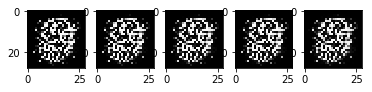

Epoch 10: Gen CE loss: 3.17 Disc CE loss 0.13 Time elapsed: 5.14 Disc acc: 0.993 Correct: 59595
Generated Images Sample:


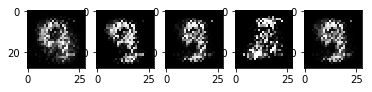

Epoch 20: Gen CE loss: 3.30 Disc CE loss 0.18 Time elapsed: 5.22 Disc acc: 0.967 Correct: 58034
Generated Images Sample:


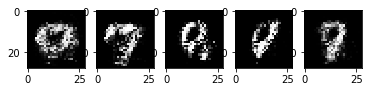

Epoch 30: Gen CE loss: 2.21 Disc CE loss 0.32 Time elapsed: 5.20 Disc acc: 0.907 Correct: 54424
Generated Images Sample:


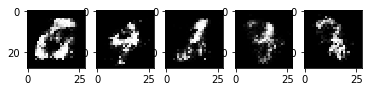

Epoch 40: Gen CE loss: 1.62 Disc CE loss 0.44 Time elapsed: 5.20 Disc acc: 0.848 Correct: 50883
Generated Images Sample:


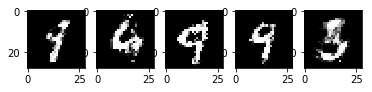

Epoch 50: Gen CE loss: 1.39 Disc CE loss 0.48 Time elapsed: 5.15 Disc acc: 0.819 Correct: 49127
Generated Images Sample:


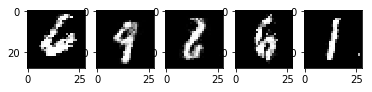

Epoch 60: Gen CE loss: 1.26 Disc CE loss 0.52 Time elapsed: 5.10 Disc acc: 0.788 Correct: 47280
Generated Images Sample:


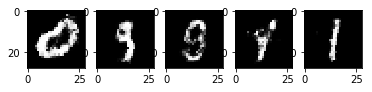

Epoch 70: Gen CE loss: 1.24 Disc CE loss 0.51 Time elapsed: 5.20 Disc acc: 0.798 Correct: 47851
Generated Images Sample:


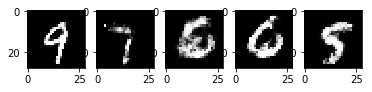

Epoch 80: Gen CE loss: 1.24 Disc CE loss 0.52 Time elapsed: 5.20 Disc acc: 0.785 Correct: 47091
Generated Images Sample:


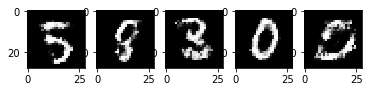

Epoch 90: Gen CE loss: 1.25 Disc CE loss 0.51 Time elapsed: 5.28 Disc acc: 0.790 Correct: 47378
Generated Images Sample:


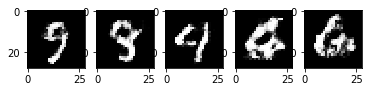

Epoch 100: Gen CE loss: 1.27 Disc CE loss 0.51 Time elapsed: 5.26 Disc acc: 0.787 Correct: 47228
Generated Images Sample:


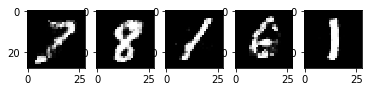

Epoch 110: Gen CE loss: 1.27 Disc CE loss 0.51 Time elapsed: 5.26 Disc acc: 0.789 Correct: 47327
Generated Images Sample:


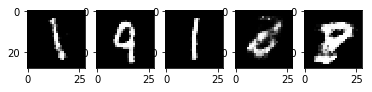

Epoch 120: Gen CE loss: 1.28 Disc CE loss 0.50 Time elapsed: 5.32 Disc acc: 0.788 Correct: 47277
Generated Images Sample:


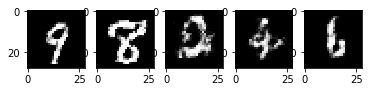

Epoch 130: Gen CE loss: 1.30 Disc CE loss 0.50 Time elapsed: 5.24 Disc acc: 0.795 Correct: 47702
Generated Images Sample:


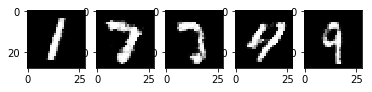

Epoch 140: Gen CE loss: 1.31 Disc CE loss 0.49 Time elapsed: 5.23 Disc acc: 0.796 Correct: 47761
Generated Images Sample:


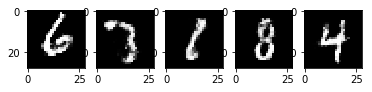

Epoch 150: Gen CE loss: 1.34 Disc CE loss 0.48 Time elapsed: 5.22 Disc acc: 0.804 Correct: 48242
Generated Images Sample:


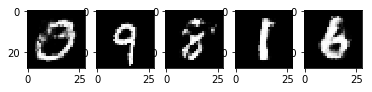

Epoch 160: Gen CE loss: 1.37 Disc CE loss 0.48 Time elapsed: 5.22 Disc acc: 0.812 Correct: 48702
Generated Images Sample:


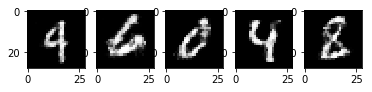

Epoch 170: Gen CE loss: 1.39 Disc CE loss 0.47 Time elapsed: 5.18 Disc acc: 0.812 Correct: 48697
Generated Images Sample:


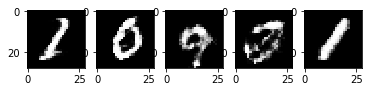

Epoch 180: Gen CE loss: 1.41 Disc CE loss 0.47 Time elapsed: 5.14 Disc acc: 0.814 Correct: 48818
Generated Images Sample:


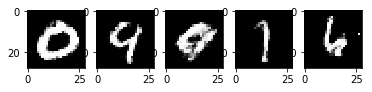

Epoch 190: Gen CE loss: 1.43 Disc CE loss 0.47 Time elapsed: 5.31 Disc acc: 0.816 Correct: 48932
Generated Images Sample:


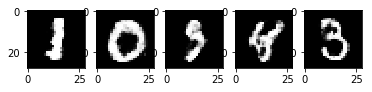

Epoch 200: Gen CE loss: 1.45 Disc CE loss 0.46 Time elapsed: 5.25 Disc acc: 0.824 Correct: 49451
Generated Images Sample:


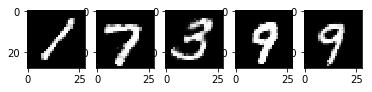

Epoch 210: Gen CE loss: 1.48 Disc CE loss 0.45 Time elapsed: 5.27 Disc acc: 0.830 Correct: 49829
Generated Images Sample:


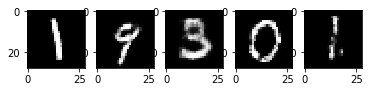

Epoch 220: Gen CE loss: 1.51 Disc CE loss 0.45 Time elapsed: 5.24 Disc acc: 0.831 Correct: 49880
Generated Images Sample:


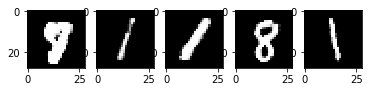

Epoch 230: Gen CE loss: 1.55 Disc CE loss 0.44 Time elapsed: 5.17 Disc acc: 0.838 Correct: 50288
Generated Images Sample:


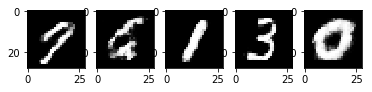

Epoch 240: Gen CE loss: 1.57 Disc CE loss 0.43 Time elapsed: 5.21 Disc acc: 0.845 Correct: 50700
Generated Images Sample:


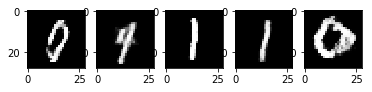

Epoch 250: Gen CE loss: 1.59 Disc CE loss 0.43 Time elapsed: 5.20 Disc acc: 0.845 Correct: 50714
Generated Images Sample:


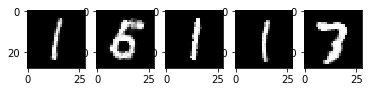

Epoch 260: Gen CE loss: 1.62 Disc CE loss 0.43 Time elapsed: 5.30 Disc acc: 0.848 Correct: 50905
Generated Images Sample:


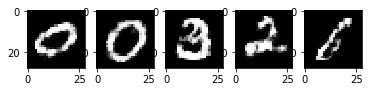

Epoch 270: Gen CE loss: 1.63 Disc CE loss 0.42 Time elapsed: 5.25 Disc acc: 0.854 Correct: 51243
Generated Images Sample:


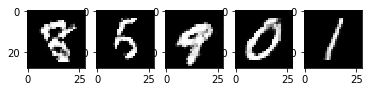

Epoch 280: Gen CE loss: 1.65 Disc CE loss 0.42 Time elapsed: 5.17 Disc acc: 0.856 Correct: 51331
Generated Images Sample:


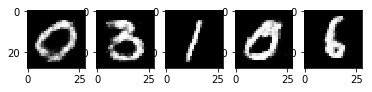

Epoch 290: Gen CE loss: 1.67 Disc CE loss 0.41 Time elapsed: 5.28 Disc acc: 0.861 Correct: 51670
Generated Images Sample:


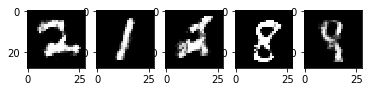

Epoch 300: Gen CE loss: 1.69 Disc CE loss 0.41 Time elapsed: 5.33 Disc acc: 0.865 Correct: 51876
Generated Images Sample:


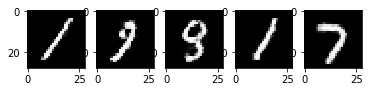

Epoch 310: Gen CE loss: 1.72 Disc CE loss 0.40 Time elapsed: 5.29 Disc acc: 0.870 Correct: 52220
Generated Images Sample:


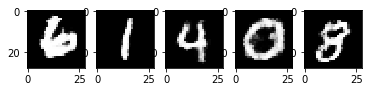

Epoch 320: Gen CE loss: 1.74 Disc CE loss 0.40 Time elapsed: 5.23 Disc acc: 0.873 Correct: 52400
Generated Images Sample:


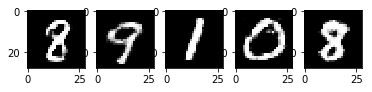

Epoch 330: Gen CE loss: 1.75 Disc CE loss 0.39 Time elapsed: 5.20 Disc acc: 0.877 Correct: 52603
Generated Images Sample:


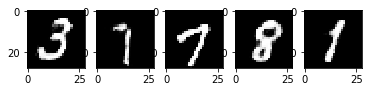

Epoch 340: Gen CE loss: 1.76 Disc CE loss 0.39 Time elapsed: 5.22 Disc acc: 0.878 Correct: 52681
Generated Images Sample:


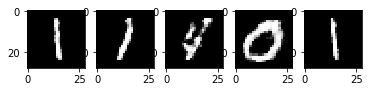

Epoch 350: Gen CE loss: 1.78 Disc CE loss 0.39 Time elapsed: 5.30 Disc acc: 0.878 Correct: 52654
Generated Images Sample:


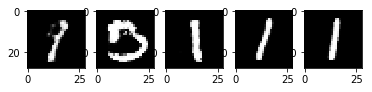

Epoch 360: Gen CE loss: 1.79 Disc CE loss 0.39 Time elapsed: 5.24 Disc acc: 0.882 Correct: 52910
Generated Images Sample:


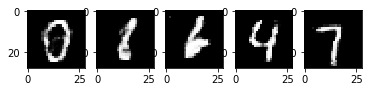

Epoch 370: Gen CE loss: 1.78 Disc CE loss 0.38 Time elapsed: 5.24 Disc acc: 0.883 Correct: 52954
Generated Images Sample:


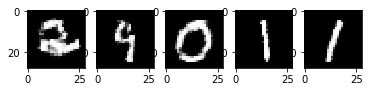

Epoch 380: Gen CE loss: 1.79 Disc CE loss 0.38 Time elapsed: 5.24 Disc acc: 0.883 Correct: 52988
Generated Images Sample:


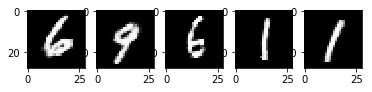

Epoch 390: Gen CE loss: 1.80 Disc CE loss 0.38 Time elapsed: 5.23 Disc acc: 0.885 Correct: 53092
Generated Images Sample:


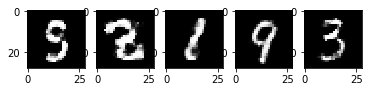

Epoch 400: Gen CE loss: 1.81 Disc CE loss 0.38 Time elapsed: 5.25 Disc acc: 0.888 Correct: 53296
Generated Images Sample:


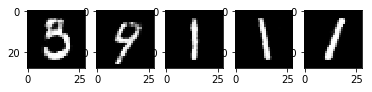

Epoch 410: Gen CE loss: 1.82 Disc CE loss 0.38 Time elapsed: 5.17 Disc acc: 0.887 Correct: 53250
Generated Images Sample:


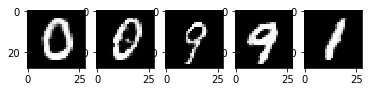

Epoch 420: Gen CE loss: 1.83 Disc CE loss 0.37 Time elapsed: 5.20 Disc acc: 0.890 Correct: 53403
Generated Images Sample:


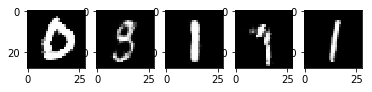

Epoch 430: Gen CE loss: 1.86 Disc CE loss 0.37 Time elapsed: 5.19 Disc acc: 0.893 Correct: 53588
Generated Images Sample:


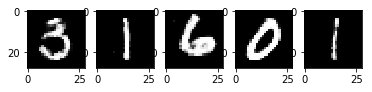

Epoch 440: Gen CE loss: 1.85 Disc CE loss 0.37 Time elapsed: 5.23 Disc acc: 0.892 Correct: 53530
Generated Images Sample:


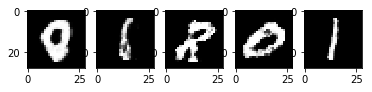

Epoch 450: Gen CE loss: 1.86 Disc CE loss 0.37 Time elapsed: 5.27 Disc acc: 0.895 Correct: 53708
Generated Images Sample:


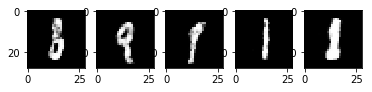

Epoch 460: Gen CE loss: 1.85 Disc CE loss 0.36 Time elapsed: 5.17 Disc acc: 0.898 Correct: 53858
Generated Images Sample:


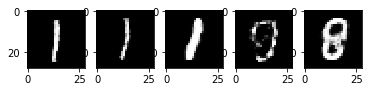

Epoch 470: Gen CE loss: 1.87 Disc CE loss 0.36 Time elapsed: 5.21 Disc acc: 0.896 Correct: 53753
Generated Images Sample:


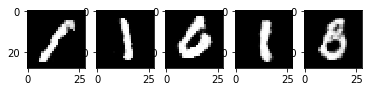

Epoch 480: Gen CE loss: 1.89 Disc CE loss 0.36 Time elapsed: 5.20 Disc acc: 0.896 Correct: 53771
Generated Images Sample:


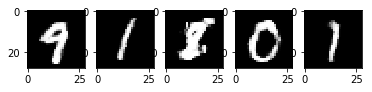

Epoch 490: Gen CE loss: 1.89 Disc CE loss 0.36 Time elapsed: 5.15 Disc acc: 0.898 Correct: 53866
Generated Images Sample:


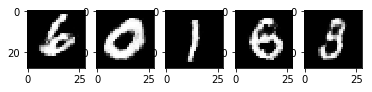

In [31]:
saved_model = []
def train_GAN(models = None, epochs = 500, learning_rate = 0.0001, disc_losses = [], gen_losses = [], accs = []):
    
    if models:
        discr = models[0]
        gen = models[1]
        
        gen_optim = models[3]
        discr_optim = models[2]
        
    else:
        discr = FC_Discriminator(28*28, 200, 50, 1).cuda()
        gen = FC_Generator(20, 50, 300, 28*28).cuda()
        gen_optim = torch.optim.Adam(gen.parameters(),lr=learning_rate*3)
        discr_optim = torch.optim.Adam(discr.parameters(),lr=learning_rate)
    
    d_loss = nn.BCELoss(size_average=False)
    
    total_exs = len(full_img)
    
    for epoch in range(epochs):
        
        batches = 0
        exs = 0
        total_gen_loss = 0
        total_disc_loss = 0
        correct = 0
        start_time = time.time()
        
        for img, _ in full_loader:
            
            batches += 1
            
            #get number of examples. could be uneven at end
            exs = img.size()[0]
            
            #images
            x_real = Variable(img.view(exs, -1)).cuda()
            x_fake = gen(exs)
            
            #labels
            y_real = Variable(torch.ones(exs)).cuda()
            y_fake = Variable(torch.zeros(exs)).cuda()
            
            y_hat_real = discr(x_real)
            y_hat_fake = discr(x_fake)
            
            real_loss = d_loss(y_hat_real.squeeze(),y_real)
            fake_loss = d_loss(y_hat_fake.squeeze(),y_fake)
            correct += int(torch.sum(y_hat_fake.lt(0.5)))
            
            #step for discriminator
            disc_loss = real_loss + fake_loss
            total_disc_loss += disc_loss
            discr.zero_grad()
            disc_loss.backward()
            discr_optim.step()
            
            #new images
            x_fake2 = gen(exs)
            y_hat_fake2 = discr(x_fake2)
            
            #step for generator
            gen_loss = d_loss(y_hat_fake2.squeeze(), y_real)
            total_gen_loss += gen_loss
            discr.zero_grad()
            gen.zero_grad()
            gen_loss.backward()
            gen_optim.step()

        total_gen_loss /= float(total_exs)
        total_disc_loss /= float(total_exs*2)
        acc = float(correct) / float(total_exs)
        
        disc_losses += [total_disc_loss]
        gen_losses += [total_gen_loss]
        accs += [acc]
        
        if epoch % 10 == 0:
            delta = time.time()-start_time

            print("Epoch %d: Gen CE loss: %.2f Disc CE loss %.2f Time elapsed: %.2f Disc acc: %.3f Correct: %d" % (epoch, total_gen_loss, total_disc_loss, delta, acc, correct))
            print("Generated Images Sample:")

            #generate and print 5 sample images
            z_ = gen(5)
            plt.figure()
            for i, image in enumerate(z_.data):
                plt.subplot(1,5,i+1)
                plt.imshow(image.view(28,28),cmap='gray')
            plt.show()
            
            
            
        saved_model[:] = [discr, gen, discr_optim, gen_optim]
        
    return (discr, gen, discr_optim, gen_optim)
            
my_gen_losses = [] 
my_disc_losses = []
my_accs = []
my_model = train_GAN(gen_losses = my_gen_losses, disc_losses= my_disc_losses, accs=my_accs)            

In [103]:
int_model = FC_Generator(20, 50, 300, 28*28).cuda()
int_model.load_state_dict(saved_model[1].state_dict())

#find two good latent signals
z1 = torch.normal(torch.zeros(20), torch.ones(20))
z2 = torch.normal(torch.zeros(20), torch.ones(20))
x1 = int_model(1,torch.stack([z1]))
x2 = int_model(1,torch.stack([z2]))

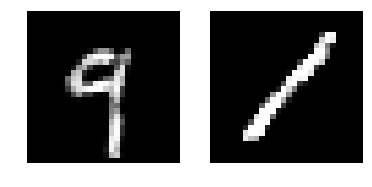

In [104]:
plt.figure()

plt.subplot(1,2,1)
plt.imshow(x2.data.view(28,28),cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(x1.data.view(28,28),cmap='gray')
plt.axis('off')

plt.show()

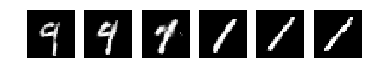

In [105]:
#perform interpolation
xs = []
alpha = [0,0.2,0.4,0.6,0.8,1]
for a in alpha:
    z = z1*a + z2*(1-a)
    im = int_model(1,torch.stack([z]))
    xs += [im.data.view(28,28)]

plt.figure()
for i,im in enumerate(xs):
    plt.subplot(1,len(xs),i+1)
    plt.imshow(im,cmap="gray")
    plt.axis('off')
plt.show()

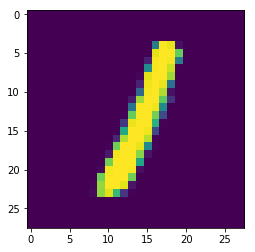

In [76]:
i1 = int_model(1,torch.stack([z1]))
plt.imshow(i1.data.view(28,28))

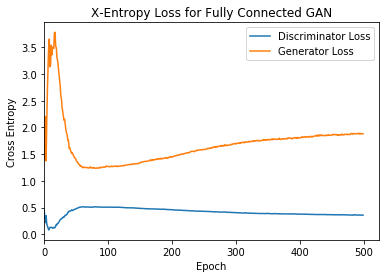

In [34]:
plt.plot([i.data[0] for i in my_disc_losses])
plt.plot([i.data[0] for i in my_gen_losses])
plt.title("X-Entropy Loss for Fully Connected GAN")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy")
plt.legend(["Discriminator Loss","Generator Loss"])
plt.xlim(xmin=0)
plt.show()

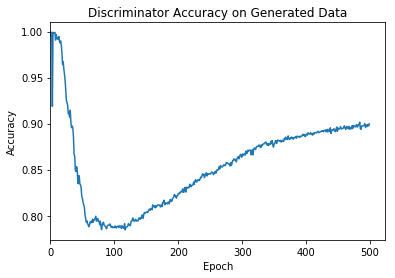

In [36]:
plt.plot([i for i in my_accs])
plt.title("Discriminator Accuracy on Generated Data")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xlim(xmin=0)
plt.show()

In [51]:
saved_model[1].l1.

AttributeError: 'Linear' object has no attribute 'data'

In [26]:
a = 100
a += 150
a += 150
a

400

In [13]:
a.size()

torch.Size([100, 1, 28, 28])